In [3]:
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt

In [4]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [5]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss  = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

In [6]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss  = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

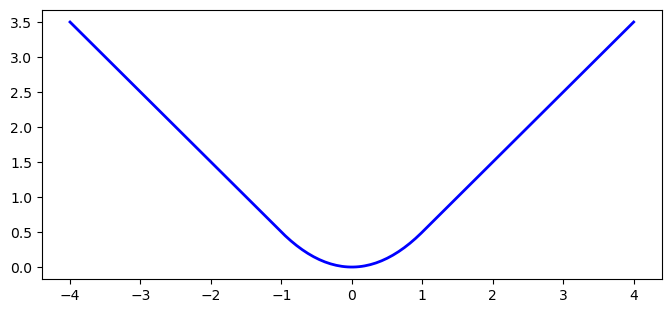

In [7]:
plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")

In [8]:
input_shape = X_train.shape[1:]

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [9]:
model.compile(loss=huber_fn, optimizer="nadam", metrics=["mae"])

In [10]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 44s 57ms/step - loss: 0.5615 - mae: 0.9235 - val_loss: 0.2651 - val_mae: 0.5605
Epoch 2/2
363/363 [==============================] - 2s 4ms/step - loss: 0.2207 - mae: 0.5156 - val_loss: 0.2260 - val_mae: 0.5118


In [11]:
model.save("my_custom_loss_model.h5")

C:\Users\dread-miles\miniconda3\envs\snakey\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
load_model=keras.models.load_model("my_custom_loss_model.h5",custom_objects={"huber_fn":huber_fn})

In [13]:
def create_huber(threshold):
    def huber_fn(y_true,y_pred):
        error=y_true-y_pred
        is_small_error=tf.abs(error)<threshold
        squared_loss=tf.square(error)/2
        linear_loss=threshold*tf.abs(error)-threshold**2/2
        return tf.where(is_small_error,squared_loss,linear_loss)
    return huber_fn

In [14]:
# lets put some threshold into our loss function
model.compile(loss=create_huber(1.0),optimizer="nadam",metrics=["mae"])

In [15]:
model.fit(X_train_scaled,y_train,epochs=3,validation_data=(X_valid,y_valid))

Epoch 1/3
363/363 [==============================] - 8s 8ms/step - loss: 0.2063 - mae: 0.4965 - val_loss: 343.2182 - val_mae: 343.7182
Epoch 2/3
363/363 [==============================] - 2s 7ms/step - loss: 0.1981 - mae: 0.4846 - val_loss: 275.9564 - val_mae: 276.4564
Epoch 3/3
363/363 [==============================] - 3s 7ms/step - loss: 0.1928 - mae: 0.4766 - val_loss: 275.6290 - val_mae: 276.1290


In [16]:
# lets customize from the keras 
class HubberLoss(keras.losses.Loss):
    def __init__(self,threshold,**kwargs):
        self.threshold=threshold
        super().__init__(**kwargs)
    def call(self,y_true,y_pred):
        error=y_true-y_pred
        is_small_error=tf.abs(error)<self.threshold
        squared_loss=tf.square(error)/2
        linear_loss=self.threshold * tf.abs(error)-self.threshold**2/2
        return tf.where(is_small_error,squared_loss,linear_loss)
    def get_config(self):
        base_config=super().get_config()
        return {**base_config,"threshold":self.threshold}

In [17]:
model2=keras.models.Sequential(
    [
        keras.layers.Dense(30,activation="selu",kernel_initializer="lecun_normal"),
        keras.layers.Dense(1)
    ]
)

In [18]:
model2.compile(loss=HubberLoss(2.),optimizer="nadam",metrics=["mse"])

In [19]:
model2.fit(X_train_scaled,y_train,epochs=5,validation_data=(X_valid,y_valid))

Epoch 1/5
363/363 [==============================] - 9s 8ms/step - loss: 0.8217 - mse: 2.0004 - val_loss: 57.3825 - val_mse: 2351.5132
Epoch 2/5
363/363 [==============================] - 5s 13ms/step - loss: 0.2518 - mse: 0.5843 - val_loss: 198.9100 - val_mse: 10856.0234
Epoch 3/5
363/363 [==============================] - 4s 12ms/step - loss: 0.2345 - mse: 0.4838 - val_loss: 331.7575 - val_mse: 33582.9531
Epoch 4/5
363/363 [==============================] - 2s 5ms/step - loss: 0.2267 - mse: 0.4648 - val_loss: 413.5237 - val_mse: 53669.3164
Epoch 5/5
363/363 [==============================] - 2s 5ms/step - loss: 0.2195 - mse: 0.4480 - val_loss: 445.3784 - val_mse: 61341.3359


In [20]:
model2.save("my_custom_loss_fn.h5")